## Import Libraries and initialise TPU

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import tensorflow.keras as keras
from keras import layers
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime!')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16*strategy.num_replicas_in_sync

Tensorflow version 2.4.1
Running on TPU  ['10.0.0.2:8470']
Number of accelerators:  8


## Using kaggle, load dataset into google cloud service

In [2]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path('dronedigit2')
print(GCS_PATH)

gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196


In [3]:
!gsutil ls $GCS_PATH

gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/0/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/1/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/2/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/3/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/4/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/5/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/6/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/7/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/8/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/9/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/A/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/B/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/C/
gs://kds-7fdb864abccc468e845e541e4d16c5c8ea07147ba63cb94016cbd196/D/
gs://kds-7fdb864abccc468e845e541e4

In [4]:
filenames = tf.io.gfile.glob(GCS_PATH+'/*/*')
image_count=len(filenames)
print(image_count)

10799


## Create dataset of shuffled list files

In [5]:
filenames_ds=tf.data.Dataset.list_files(str(GCS_PATH+'/*/*.png'),shuffle=False)
filenames_ds=filenames_ds.shuffle(image_count, reshuffle_each_iteration=False)

### Split data set according to testing, validation and training
Here a split of 10%, 20% and 70% is used.

In [6]:
test_split=0.1
val_split=0.2
train_split=0.7

assert (test_split+val_split+train_split) == 1, "Incorrect Splitting"

train_size=int(image_count*train_split)
val_size=int(image_count*val_split)


train_ds=filenames_ds.take(train_size)
val_ds=filenames_ds.skip(train_size).take(val_size)
test_ds=filenames_ds.skip(train_size).skip(val_size)

# Define Classes
class_names=["0","1","2","3","4","5","6","7","8","9",
             "A","B","C","D","E","F","G","H","I","J","K","L","M",
             "N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

In [7]:
print(train_ds.__len__())
print(val_ds.__len__())
print(test_ds.__len__())

tf.Tensor(7559, shape=(), dtype=int64)
tf.Tensor(2159, shape=(), dtype=int64)
tf.Tensor(1081, shape=(), dtype=int64)


### Data Pipeline
The file path is used to deocde the PNG image and resize it to 128, then the image is labelled based on the directory of the file.
The train, test and validation images are then mapped using the defined functions. The data is then configured to be use efficiently by the TPU.

In [8]:
import os

def get_label(file_path):
    parts=tf.strings.split(file_path,os.path.sep)
    one_hot=parts[-2]==class_names
    return tf.argmax(one_hot)

def decode_img(img):
    img=tf.io.decode_png(img, channels=1)
    return tf.image.resize(img,[128,128])

def process_path(file_path):
    label=get_label(file_path)
    img=tf.io.read_file(file_path)
    img=decode_img(img)
    return img, label

train_ds=train_ds.map(process_path,num_parallel_calls=AUTOTUNE)
val_ds=val_ds.map(process_path,num_parallel_calls=AUTOTUNE)
test_ds=test_ds.map(process_path,num_parallel_calls=AUTOTUNE)

In [9]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

def configure_for_performance(ds):
    ds = ds.map(convert_to_float)
    ds = ds.cache()
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)


## Visualise Image and Label

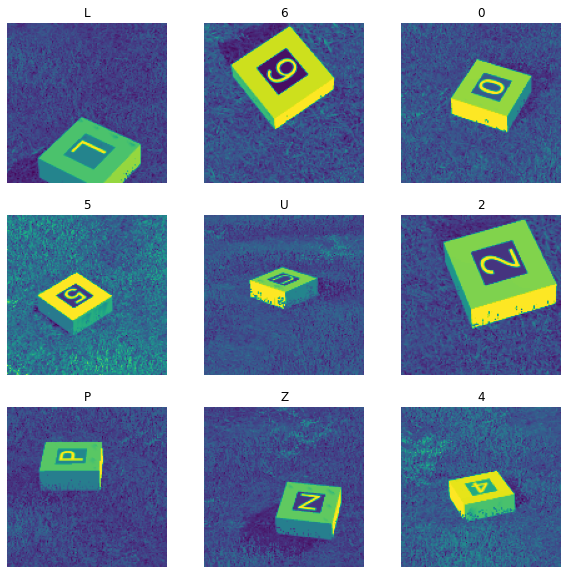

In [10]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

## Model Definition

In [11]:
def create_model():
    model=keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 1)),

        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),
        layers.Dropout(0.3),
        
        
        layers.Flatten(),
        layers.Dense(512,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.95),
        layers.Dense(36, activation='softmax')
        
    ])
    return model

In [12]:
from keras.callbacks import ReduceLROnPlateau
with strategy.scope():
    model=create_model()
    
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.003),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=75,
    min_delta=0.00001,
    restore_best_weights=True
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        2

## Fitting
The model is fitted to the training data.

In [14]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stopping]
)

Epoch 1/1000
59/59 [==============================] - 216s 4s/step - loss: 9.8116 - sparse_categorical_accuracy: 0.0268 - val_loss: 4.3710 - val_sparse_categorical_accuracy: 0.0259
Epoch 2/1000
59/59 [==============================] - 3s 49ms/step - loss: 6.9022 - sparse_categorical_accuracy: 0.0251 - val_loss: 6.2701 - val_sparse_categorical_accuracy: 0.0264
Epoch 3/1000
59/59 [==============================] - 2s 41ms/step - loss: 5.2919 - sparse_categorical_accuracy: 0.0279 - val_loss: 3.7058 - val_sparse_categorical_accuracy: 0.0278
Epoch 4/1000
59/59 [==============================] - 2s 40ms/step - loss: 4.5231 - sparse_categorical_accuracy: 0.0289 - val_loss: 3.6699 - val_sparse_categorical_accuracy: 0.0273
Epoch 5/1000
59/59 [==============================] - 2s 41ms/step - loss: 4.1699 - sparse_categorical_accuracy: 0.0284 - val_loss: 6.6938 - val_sparse_categorical_accuracy: 0.0210
Epoch 6/1000
59/59 [==============================] - 2s 40ms/step - loss: 4.1386 - sparse_cate

## Visualising Loss and Accuracy Curves

(0.0, 8.5)

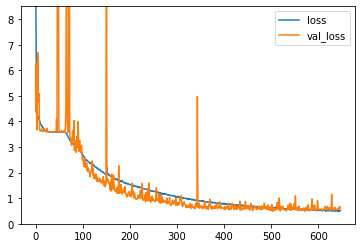

In [15]:
history_df=pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
plt.ylim([0,8.5])

<AxesSubplot:>

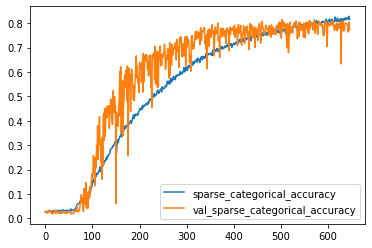

In [16]:
history_df.loc[:,['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()

There is little to no sign of overfitting or underfitting.

## Predict the testing images and evaluate performance

In [17]:
for image, label in test_ds.unbatch().batch(1080):
    numpy_images=image.numpy()
    numpy_label=label.numpy()

predictions=model.predict(numpy_images)
evaluations=model.evaluate(numpy_images,numpy_label)

32/32 [==============================] - 4s 15ms/step - loss: 0.4907 - sparse_categorical_accuracy: 0.8164


81.6% accuracy - not bad although improvements could be made such as but not limited to increasing the model complexity, model tuning or using further data generation techniques. This is however sufficient for the level of project undertaken.

## Visualising predictions

<AxesSubplot:>

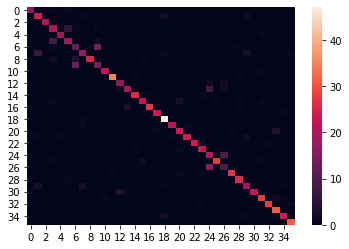

In [18]:
y_pred_i=np.argmax(predictions,axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(numpy_label,y_pred_i))

Overall, really good predictions however, model appears to incorrectly identify similar alphanumerics. Lets visualise these alphanumerics: 

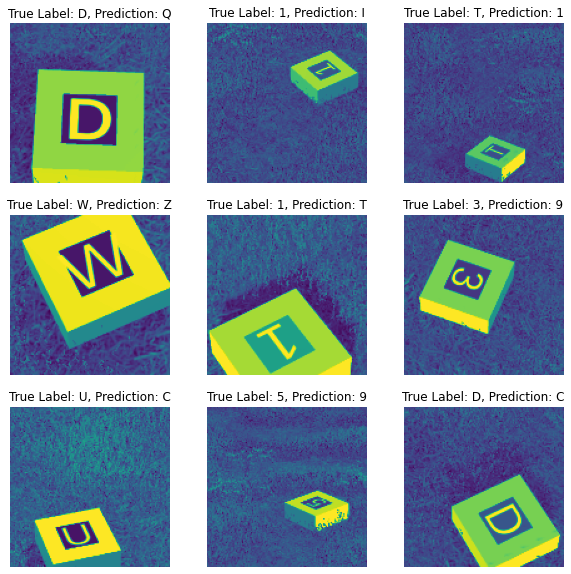

In [19]:
false_index=np.where(np.not_equal(numpy_label, y_pred_i))[0]

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(numpy_images[false_index[i]].astype("uint8"))
    true_label = numpy_label[false_index[i]]
    pred_label = y_pred_i[false_index[i]]
    plt.title("True Label: " + class_names[true_label] + ", Prediction: " + class_names[pred_label])
    plt.axis("off")

Model confuses similar looking alphanumerics. Below is a grouped list of confusions:

* D, Q, O and 0
* 1, 7, I
* 6, 9
* A, 4
* N, M
* U, C


This is 15/36 characters which is really high. This may mean that the model should be further tuned.

## Save model and weights

In [20]:
model.save('droneANI.h5')